In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.cloud import bigquery
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [2]:
# set display options to show all columns
pd.set_option('display.max_columns', None)
# Set the float format to display numbers without scientific notation
pd.options.display.float_format = '{:.2f}'.format
# Set the client for future queries to BigQuery
client = bigquery.Client(project = "continente-lced-feup")
#data_table.enable_dataframe_formatter()
#auth.authenticate_user()

In [3]:
!gcloud auth application-default login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=4746G0YwCdAXEs3SbEuH0qRS0bA7ct&access_type=offline&code_challenge=blSG8OhOiR6KYM500-ysp513cDxRLEmJN4syWfD68Ds&code_challenge_method=S256


Credentials saved to file: [C:\Users\iankk\AppData\Roaming\gcloud\application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "egd-project" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the project owning t

In [4]:
# Feature engineering #
# get transcations data
# total transactions
# total net amount 
# total gross amount
# average amount per transaction
# average number of products per transaction
# average number of days between transactions
# number of different products bought
# Number of different subcategories bought
# number of different categories bought
# average number of sub categories bought per transaction
# average number of products bought per transaction
# average value per product bought

In [5]:
query = client.query("""
   select * from `tables_raw.dim_customer` as customer
where SEG_AGE_DSC = ']25;35]'
   """)

df_customer = query.result().to_dataframe() # Wait for the job to complete.
display(df_customer.head())

,CUSTOMER_ACCOUNT_NR_MASK,GENDER,FAMILY_MEMBERS,CP4,seg_lifestyle_cd,seg_lifestyle_dsc,SEG_AGE,SEG_AGE_DSC,seg_lifestage_cd,seg_lifestage_dsc
0,3237018,M,3,2460,1,Qualidade,SA_3,]25;35],2,Senior
1,12477319,M,5,2580,1,Qualidade,SA_3,]25;35],2,Senior
2,4323319,F,3,2650,1,Qualidade,SA_3,]25;35],2,Senior
3,4671866,F,3,1750,1,Qualidade,SA_3,]25;35],2,Senior
4,13171827,M,3,2720,1,Qualidade,SA_3,]25;35],2,Senior


In [6]:
query = client.query("""
    select * from `tables_raw.dim_customer` as customer
INNER JOIN `tables_raw.fact_transaction` as fct on fct.CUSTOMER_ACCOUNT_NR_MASK = customer.CUSTOMER_ACCOUNT_NR_MASK
where SEG_AGE_DSC = ']25;35]'
    """)
df_transactions = query.result().to_dataframe() # Wait for the job to complete.
display(df_transactions.head())

,CUSTOMER_ACCOUNT_NR_MASK,GENDER,FAMILY_MEMBERS,CP4,seg_lifestyle_cd,seg_lifestyle_dsc,SEG_AGE,SEG_AGE_DSC,seg_lifestage_cd,seg_lifestage_dsc,TIME_KEY,TRANSACTION_ID_MASK,CUSTOMER_ACCOUNT_NR_MASK_1,LOC_BRAND_CD,LOCATION_CD,POS_TP_CD,SKU,PRODUCT_KEY,QTY,NET_SLS_AMT,GROSS_SLS_AMT,PROD_DSCNT_ISSUED_AMT,TRANS_DSCNT_RAT_AMT,DIRECT_DSCNT_AMT
0,83590800,M,<NA>,0000,2,Família,SA_3,]25;35],3,Family w/ Young Adul,20221108,8760826952541943853,83590800.00,143,14,P,4337460,4337460010001,1.00,0.72,0.89,0.00,0.00,0.00
1,86340438,M,2,2330,3,Preço,SA_3,]25;35],6,No Value,20210103,6935047705963805796,86340438.00,143,468,P,5155145,5155145010001,1.00,0.72,0.89,0.00,0.00,0.10
2,4096988,M,1,4620,2,Família,SA_3,]25;35],4,Family with Kids,20220822,8684013526789035600,4096988.00,143,202,P,5113361,5113361010001,1.00,0.72,0.89,0.00,0.00,0.00
3,11315241,M,0,3730,2,Família,SA_3,]25;35],4,Family with Kids,20220304,8800128144181998331,11315241.00,143,210,P,7402091,7402091010001,1.00,0.72,0.89,0.00,0.13,0.20
4,51349560,F,1,6230,1,Qualidade,SA_3,]25;35],5,Active Adults,20221112,8766115549715230792,51349560.00,143,212,P,7571617,7571617010001,1.00,0.72,0.89,0.00,0.00,0.00


In [7]:

### Total transactions per client ###
df = pd.DataFrame()
df = df_transactions.groupby('CUSTOMER_ACCOUNT_NR_MASK')['TIME_KEY'].nunique()
df = pd.DataFrame(df).reset_index().rename(columns={'TIME_KEY':'total_transactions'})
df_customer = df_customer.merge(df, on='CUSTOMER_ACCOUNT_NR_MASK', how='left')



In [8]:
df_customer

,CUSTOMER_ACCOUNT_NR_MASK,GENDER,FAMILY_MEMBERS,CP4,seg_lifestyle_cd,seg_lifestyle_dsc,SEG_AGE,SEG_AGE_DSC,seg_lifestage_cd,seg_lifestage_dsc,total_transactions
0,3237018,M,3,2460,1,Qualidade,SA_3,]25;35],2,Senior,66.00
1,12477319,M,5,2580,1,Qualidade,SA_3,]25;35],2,Senior,30.00
2,4323319,F,3,2650,1,Qualidade,SA_3,]25;35],2,Senior,62.00
3,4671866,F,3,1750,1,Qualidade,SA_3,]25;35],2,Senior,89.00
4,13171827,M,3,2720,1,Qualidade,SA_3,]25;35],2,Senior,151.00
...,...,...,...,...,...,...,...,...,...,...,...
12919,62861855,M,<NA>,4520,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,20.00
12920,50687926,M,<NA>,4745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,3.00
12921,119273374,F,<NA>,2745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,5.00
12922,125331917,None,<NA>,1150,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,1.00


In [9]:
### Total Net amount per client ###
df = pd.DataFrame()
df = df_transactions.groupby('CUSTOMER_ACCOUNT_NR_MASK')['NET_SLS_AMT'].sum()
df = pd.DataFrame(df).reset_index().rename(columns={'NET_SLS_AMT':'total_net_amount'})
df_customer = df_customer.merge(df, on='CUSTOMER_ACCOUNT_NR_MASK', how='left')



In [10]:
df_customer

,CUSTOMER_ACCOUNT_NR_MASK,GENDER,FAMILY_MEMBERS,CP4,seg_lifestyle_cd,seg_lifestyle_dsc,SEG_AGE,SEG_AGE_DSC,seg_lifestage_cd,seg_lifestage_dsc,total_transactions,total_net_amount
0,3237018,M,3,2460,1,Qualidade,SA_3,]25;35],2,Senior,66.00,1103.92
1,12477319,M,5,2580,1,Qualidade,SA_3,]25;35],2,Senior,30.00,1090.22
2,4323319,F,3,2650,1,Qualidade,SA_3,]25;35],2,Senior,62.00,2417.96
3,4671866,F,3,1750,1,Qualidade,SA_3,]25;35],2,Senior,89.00,10753.01
4,13171827,M,3,2720,1,Qualidade,SA_3,]25;35],2,Senior,151.00,6082.79
...,...,...,...,...,...,...,...,...,...,...,...,...
12919,62861855,M,<NA>,4520,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,20.00,825.00
12920,50687926,M,<NA>,4745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,3.00,63.72
12921,119273374,F,<NA>,2745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,5.00,225.31
12922,125331917,None,<NA>,1150,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,1.00,7.69


In [11]:
### Total Gross amount per client ###
df = pd.DataFrame()
df = df_transactions.groupby('CUSTOMER_ACCOUNT_NR_MASK')['GROSS_SLS_AMT'].sum()
df = pd.DataFrame(df).reset_index().rename(columns={'GROSS_SLS_AMT':'total_gross_amount'})
df_customer = df_customer.merge(df, on='CUSTOMER_ACCOUNT_NR_MASK', how='left')


In [12]:
df_customer

,CUSTOMER_ACCOUNT_NR_MASK,GENDER,FAMILY_MEMBERS,CP4,seg_lifestyle_cd,seg_lifestyle_dsc,SEG_AGE,SEG_AGE_DSC,seg_lifestage_cd,seg_lifestage_dsc,total_transactions,total_net_amount,total_gross_amount
0,3237018,M,3,2460,1,Qualidade,SA_3,]25;35],2,Senior,66.00,1103.92,1290.98
1,12477319,M,5,2580,1,Qualidade,SA_3,]25;35],2,Senior,30.00,1090.22,1280.20
2,4323319,F,3,2650,1,Qualidade,SA_3,]25;35],2,Senior,62.00,2417.96,2771.41
3,4671866,F,3,1750,1,Qualidade,SA_3,]25;35],2,Senior,89.00,10753.01,12442.14
4,13171827,M,3,2720,1,Qualidade,SA_3,]25;35],2,Senior,151.00,6082.79,6935.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12919,62861855,M,<NA>,4520,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,20.00,825.00,991.51
12920,50687926,M,<NA>,4745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,3.00,63.72,78.38
12921,119273374,F,<NA>,2745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,5.00,225.31,283.82
12922,125331917,None,<NA>,1150,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,1.00,7.69,9.37


In [13]:
### Average amount per transaction per customer and per day ###
df = pd.DataFrame()
df = df_transactions.groupby(['CUSTOMER_ACCOUNT_NR_MASK', 'TIME_KEY'])['NET_SLS_AMT'].mean()
df = df.groupby('CUSTOMER_ACCOUNT_NR_MASK').mean()
df = df.drop(columns=['TIME_KEY'])
df = pd.DataFrame(df).reset_index().rename(columns={'NET_SLS_AMT':'avg_amount_per_transaction'})
df_customer = df_customer.merge(df, on='CUSTOMER_ACCOUNT_NR_MASK', how='left')

In [14]:
df_customer

,CUSTOMER_ACCOUNT_NR_MASK,GENDER,FAMILY_MEMBERS,CP4,seg_lifestyle_cd,seg_lifestyle_dsc,SEG_AGE,SEG_AGE_DSC,seg_lifestage_cd,seg_lifestage_dsc,total_transactions,total_net_amount,total_gross_amount,avg_amount_per_transaction
0,3237018,M,3,2460,1,Qualidade,SA_3,]25;35],2,Senior,66.00,1103.92,1290.98,2.59
1,12477319,M,5,2580,1,Qualidade,SA_3,]25;35],2,Senior,30.00,1090.22,1280.20,3.75
2,4323319,F,3,2650,1,Qualidade,SA_3,]25;35],2,Senior,62.00,2417.96,2771.41,3.24
3,4671866,F,3,1750,1,Qualidade,SA_3,]25;35],2,Senior,89.00,10753.01,12442.14,2.81
4,13171827,M,3,2720,1,Qualidade,SA_3,]25;35],2,Senior,151.00,6082.79,6935.27,3.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12919,62861855,M,<NA>,4520,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,20.00,825.00,991.51,4.69
12920,50687926,M,<NA>,4745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,3.00,63.72,78.38,13.94
12921,119273374,F,<NA>,2745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,5.00,225.31,283.82,6.32
12922,125331917,None,<NA>,1150,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,1.00,7.69,9.37,2.56


In [15]:
### Average number of products per transaction per customer and per day ###
df = pd.DataFrame()
df = df_transactions.groupby(['CUSTOMER_ACCOUNT_NR_MASK', 'TIME_KEY'])['TRANSACTION_ID_MASK'].count()
df = df.groupby('CUSTOMER_ACCOUNT_NR_MASK').mean()
df = pd.DataFrame(df).reset_index().rename(columns={'TRANSACTION_ID_MASK':'avg_number_of_products_per_transaction'})
df_customer = df_customer.merge(df, on='CUSTOMER_ACCOUNT_NR_MASK', how='left')

In [16]:
df_customer

,CUSTOMER_ACCOUNT_NR_MASK,GENDER,FAMILY_MEMBERS,CP4,seg_lifestyle_cd,seg_lifestyle_dsc,SEG_AGE,SEG_AGE_DSC,seg_lifestage_cd,seg_lifestage_dsc,total_transactions,total_net_amount,total_gross_amount,avg_amount_per_transaction,avg_number_of_products_per_transaction
0,3237018,M,3,2460,1,Qualidade,SA_3,]25;35],2,Senior,66.00,1103.92,1290.98,2.59,7.24
1,12477319,M,5,2580,1,Qualidade,SA_3,]25;35],2,Senior,30.00,1090.22,1280.20,3.75,11.43
2,4323319,F,3,2650,1,Qualidade,SA_3,]25;35],2,Senior,62.00,2417.96,2771.41,3.24,13.85
3,4671866,F,3,1750,1,Qualidade,SA_3,]25;35],2,Senior,89.00,10753.01,12442.14,2.81,47.90
4,13171827,M,3,2720,1,Qualidade,SA_3,]25;35],2,Senior,151.00,6082.79,6935.27,3.30,13.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12919,62861855,M,<NA>,4520,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,20.00,825.00,991.51,4.69,13.20
12920,50687926,M,<NA>,4745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,3.00,63.72,78.38,13.94,2.00
12921,119273374,F,<NA>,2745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,5.00,225.31,283.82,6.32,10.00
12922,125331917,None,<NA>,1150,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,1.00,7.69,9.37,2.56,3.00


In [17]:
### Average number of days between transactions per customer ###
df = pd.DataFrame()
df = df_transactions.groupby(['CUSTOMER_ACCOUNT_NR_MASK'])['TIME_KEY'].apply(lambda x: x.sort_values().diff().mean())
df = pd.DataFrame(df).reset_index().rename(columns={'TIME_KEY':'avg_number_of_days_between_transactions'})
df_customer = df_customer.merge(df, on='CUSTOMER_ACCOUNT_NR_MASK', how='left')


In [18]:
df_customer

,CUSTOMER_ACCOUNT_NR_MASK,GENDER,FAMILY_MEMBERS,CP4,seg_lifestyle_cd,seg_lifestyle_dsc,SEG_AGE,SEG_AGE_DSC,seg_lifestage_cd,seg_lifestage_dsc,total_transactions,total_net_amount,total_gross_amount,avg_amount_per_transaction,avg_number_of_products_per_transaction,avg_number_of_days_between_transactions
0,3237018,M,3,2460,1,Qualidade,SA_3,]25;35],2,Senior,66.00,1103.92,1290.98,2.59,7.24,23.32
1,12477319,M,5,2580,1,Qualidade,SA_3,]25;35],2,Senior,30.00,1090.22,1280.20,3.75,11.43,32.22
2,4323319,F,3,2650,1,Qualidade,SA_3,]25;35],2,Senior,62.00,2417.96,2771.41,3.24,13.85,12.95
3,4671866,F,3,1750,1,Qualidade,SA_3,]25;35],2,Senior,89.00,10753.01,12442.14,2.81,47.90,2.60
4,13171827,M,3,2720,1,Qualidade,SA_3,]25;35],2,Senior,151.00,6082.79,6935.27,3.30,13.06,5.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12919,62861855,M,<NA>,4520,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,20.00,825.00,991.51,4.69,13.20,42.21
12920,50687926,M,<NA>,4745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,3.00,63.72,78.38,13.94,2.00,78.20
12921,119273374,F,<NA>,2745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,5.00,225.31,283.82,6.32,10.00,6.45
12922,125331917,None,<NA>,1150,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,1.00,7.69,9.37,2.56,3.00,0.00


In [19]:
### Number of different products bought per customer ###
df = pd.DataFrame()
df = df_transactions.groupby(['CUSTOMER_ACCOUNT_NR_MASK'])['PRODUCT_KEY'].nunique()
df = pd.DataFrame(df).reset_index().rename(columns={'PRODUCT_KEY':'number_of_different_products_bought'})
df_customer = df_customer.merge(df, on='CUSTOMER_ACCOUNT_NR_MASK', how='left')

In [20]:
df_customer

,CUSTOMER_ACCOUNT_NR_MASK,GENDER,FAMILY_MEMBERS,CP4,seg_lifestyle_cd,seg_lifestyle_dsc,SEG_AGE,SEG_AGE_DSC,seg_lifestage_cd,seg_lifestage_dsc,total_transactions,total_net_amount,total_gross_amount,avg_amount_per_transaction,avg_number_of_products_per_transaction,avg_number_of_days_between_transactions,number_of_different_products_bought
0,3237018,M,3,2460,1,Qualidade,SA_3,]25;35],2,Senior,66.00,1103.92,1290.98,2.59,7.24,23.32,269.00
1,12477319,M,5,2580,1,Qualidade,SA_3,]25;35],2,Senior,30.00,1090.22,1280.20,3.75,11.43,32.22,299.00
2,4323319,F,3,2650,1,Qualidade,SA_3,]25;35],2,Senior,62.00,2417.96,2771.41,3.24,13.85,12.95,612.00
3,4671866,F,3,1750,1,Qualidade,SA_3,]25;35],2,Senior,89.00,10753.01,12442.14,2.81,47.90,2.60,1413.00
4,13171827,M,3,2720,1,Qualidade,SA_3,]25;35],2,Senior,151.00,6082.79,6935.27,3.30,13.06,5.65,672.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12919,62861855,M,<NA>,4520,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,20.00,825.00,991.51,4.69,13.20,42.21,219.00
12920,50687926,M,<NA>,4745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,3.00,63.72,78.38,13.94,2.00,78.20,5.00
12921,119273374,F,<NA>,2745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,5.00,225.31,283.82,6.32,10.00,6.45,37.00
12922,125331917,None,<NA>,1150,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,1.00,7.69,9.37,2.56,3.00,0.00,3.00


In [21]:
# average number of products bought per transaction
df = pd.DataFrame()
df = df_transactions.groupby(['CUSTOMER_ACCOUNT_NR_MASK'])['PRODUCT_KEY'].count() / df_transactions.groupby(['CUSTOMER_ACCOUNT_NR_MASK'])['TIME_KEY'].nunique()
df = pd.DataFrame(df).reset_index().rename(columns={0:'avg_number_of_products_bought_per_transaction'})
df_customer = df_customer.merge(df, on='CUSTOMER_ACCOUNT_NR_MASK', how='left')


In [22]:
df_customer

,CUSTOMER_ACCOUNT_NR_MASK,GENDER,FAMILY_MEMBERS,CP4,seg_lifestyle_cd,seg_lifestyle_dsc,SEG_AGE,SEG_AGE_DSC,seg_lifestage_cd,seg_lifestage_dsc,total_transactions,total_net_amount,total_gross_amount,avg_amount_per_transaction,avg_number_of_products_per_transaction,avg_number_of_days_between_transactions,number_of_different_products_bought,avg_number_of_products_bought_per_transaction
0,3237018,M,3,2460,1,Qualidade,SA_3,]25;35],2,Senior,66.00,1103.92,1290.98,2.59,7.24,23.32,269.00,7.24
1,12477319,M,5,2580,1,Qualidade,SA_3,]25;35],2,Senior,30.00,1090.22,1280.20,3.75,11.43,32.22,299.00,11.43
2,4323319,F,3,2650,1,Qualidade,SA_3,]25;35],2,Senior,62.00,2417.96,2771.41,3.24,13.85,12.95,612.00,13.85
3,4671866,F,3,1750,1,Qualidade,SA_3,]25;35],2,Senior,89.00,10753.01,12442.14,2.81,47.90,2.60,1413.00,47.90
4,13171827,M,3,2720,1,Qualidade,SA_3,]25;35],2,Senior,151.00,6082.79,6935.27,3.30,13.06,5.65,672.00,13.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12919,62861855,M,<NA>,4520,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,20.00,825.00,991.51,4.69,13.20,42.21,219.00,13.20
12920,50687926,M,<NA>,4745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,3.00,63.72,78.38,13.94,2.00,78.20,5.00,2.00
12921,119273374,F,<NA>,2745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,5.00,225.31,283.82,6.32,10.00,6.45,37.00,10.00
12922,125331917,None,<NA>,1150,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,1.00,7.69,9.37,2.56,3.00,0.00,3.00,3.00


In [23]:
# average value per product bought
df = pd.DataFrame()
df = df_transactions.groupby(['CUSTOMER_ACCOUNT_NR_MASK'])['NET_SLS_AMT'].sum() / df_transactions.groupby(['CUSTOMER_ACCOUNT_NR_MASK'])['PRODUCT_KEY'].nunique()
df = pd.DataFrame(df).reset_index().rename(columns={0:'avg_value_per_product_bought'})
df_customer = df_customer.merge(df, on='CUSTOMER_ACCOUNT_NR_MASK', how='left')

In [24]:
df_customer

,CUSTOMER_ACCOUNT_NR_MASK,GENDER,FAMILY_MEMBERS,CP4,seg_lifestyle_cd,seg_lifestyle_dsc,SEG_AGE,SEG_AGE_DSC,seg_lifestage_cd,seg_lifestage_dsc,total_transactions,total_net_amount,total_gross_amount,avg_amount_per_transaction,avg_number_of_products_per_transaction,avg_number_of_days_between_transactions,number_of_different_products_bought,avg_number_of_products_bought_per_transaction,avg_value_per_product_bought
0,3237018,M,3,2460,1,Qualidade,SA_3,]25;35],2,Senior,66.00,1103.92,1290.98,2.59,7.24,23.32,269.00,7.24,4.10
1,12477319,M,5,2580,1,Qualidade,SA_3,]25;35],2,Senior,30.00,1090.22,1280.20,3.75,11.43,32.22,299.00,11.43,3.65
2,4323319,F,3,2650,1,Qualidade,SA_3,]25;35],2,Senior,62.00,2417.96,2771.41,3.24,13.85,12.95,612.00,13.85,3.95
3,4671866,F,3,1750,1,Qualidade,SA_3,]25;35],2,Senior,89.00,10753.01,12442.14,2.81,47.90,2.60,1413.00,47.90,7.61
4,13171827,M,3,2720,1,Qualidade,SA_3,]25;35],2,Senior,151.00,6082.79,6935.27,3.30,13.06,5.65,672.00,13.06,9.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12919,62861855,M,<NA>,4520,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,20.00,825.00,991.51,4.69,13.20,42.21,219.00,13.20,3.77
12920,50687926,M,<NA>,4745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,3.00,63.72,78.38,13.94,2.00,78.20,5.00,2.00,12.74
12921,119273374,F,<NA>,2745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,5.00,225.31,283.82,6.32,10.00,6.45,37.00,10.00,6.09
12922,125331917,None,<NA>,1150,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,1.00,7.69,9.37,2.56,3.00,0.00,3.00,3.00,2.56


In [26]:
# Remove cd columns
df_customer.drop(['seg_lifestyle_cd', 'seg_lifestage_cd','SEG_AGE','CUSTOMER_ACCOUNT_NR_MASK','CP4'], axis=1, inplace=True)

In [37]:
### Get Dummies from categorical columns ###
df_customer = pd.get_dummies(df_customer, columns=['SEG_AGE_DSC','seg_lifestyle_dsc','seg_lifestage_dsc','GENDER'])

In [40]:
df_customer.fillna(0, inplace=True)

In [41]:
### to do
# number of different categories bought
# Number of different subcategories bought per customer
# average number of sub categories bought per transaction

In [43]:
model = KMeans(n_clusters=3, random_state=0).fit(df_customer)
model.labels_


array([0, 0, 2, ..., 0, 0, 0])

In [44]:
df_customer['cluster'] = model.labels_

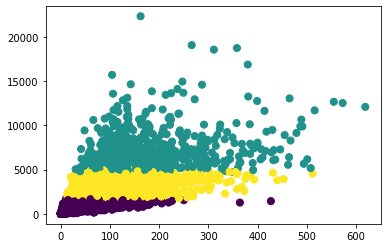

In [46]:
# Plot the clusters obtained using k means
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(df_customer['total_transactions'],df_customer['total_net_amount'], c=df_customer['cluster'],s=50)

In [47]:
model_db = DBSCAN(eps=0.3, min_samples=10).fit(df_customer)

In [48]:
df_customer['cluster_db'] = model_db.labels_

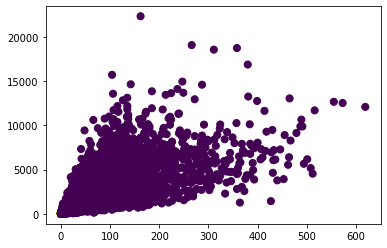

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(df_customer['total_transactions'],df_customer['total_net_amount'], c=df_customer['cluster_db'],s=50)